# Add forbidden z region

In [1]:
import molsysmt as msm

In [2]:
import openmm as mm
from openmm import unit
from openmm import app
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

In [3]:
system = mm.System()
system.addParticle(39.948 * unit.amu) # masa del átomo de argón

0

In [4]:
msm.thirds.openmm.forces.add_forbidden_z_region(system, z0='1.0 nm', width='1.5 nm',
                                              force_constant = '5000 kilojoules/(mol*angstroms**2)',
                                              pbc=True)

0

In [6]:
# Formalismo NVT
temperature = 300*unit.kelvin

In [7]:
integration_timestep = 2.0*unit.femtoseconds
saving_timestep = 1.00*unit.picoseconds
simulation_time = 1000.*unit.picoseconds

saving_steps = int(saving_timestep/integration_timestep)
num_saving_steps = int(simulation_time/saving_timestep)

In [8]:
friction   = 5.0/unit.picoseconds
integrator = mm.LangevinIntegrator(temperature, friction, integration_timestep)

In [9]:
platform = mm.Platform.getPlatformByName('OpenCL')

In [10]:
times = np.zeros(num_saving_steps, np.float32) * unit.picoseconds
positions  = np.zeros([num_saving_steps,3], np.float32) * unit.nanometers
velocities = np.zeros([num_saving_steps,3], np.float32) * unit.nanometers/unit.picosecond
potential_energies   = np.zeros([num_saving_steps], np.float32) * unit.kilocalories_per_mole
kinetic_energies     = np.zeros([num_saving_steps], np.float32) * unit.kilocalories_per_mole

In [11]:
initial_positions  = [[0.0, 0.0, 2.0]] * unit.nanometers

In [12]:
context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)

In [13]:
L = 2.0
v1 = [L,0,0] * unit.nanometers
v2 = [0,L,0] * unit.nanometers
v3 = [0,0,L] * unit.nanometers
L = L * unit.nanometers
context.setPeriodicBoxVectors(v1, v2, v3)

In [14]:
state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)

In [15]:
times[0] =  state.getTime()
positions[0] = state.getPositions()[0]
velocities[0] = state.getVelocities()[0]
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

In [16]:
for ii in tqdm(range(1,num_saving_steps)):
    context.getIntegrator().step(saving_steps)
    state_xx = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times[ii] = state_xx.getTime()
    positions[ii] = state_xx.getPositions()[0]
    velocities[ii] = state_xx.getVelocities()[0]
    kinetic_energies[ii]=state_xx.getKineticEnergy()
    potential_energies[ii]=state_xx.getPotentialEnergy()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:22<00:00, 44.83it/s]


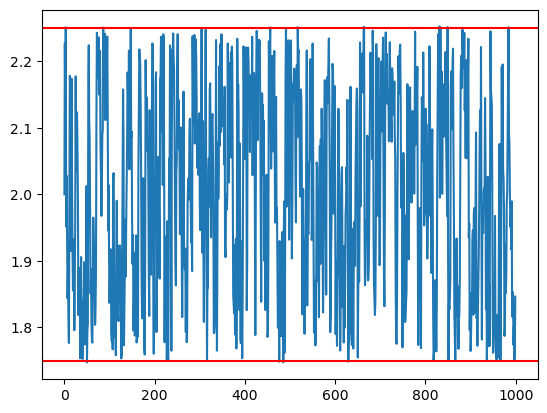

In [17]:
plt.plot(times, positions[:,2])
plt.axhline(y=2.25, color='red', linestyle='-')
plt.axhline(y=1.75, color='red', linestyle='-')
plt.show()